In [123]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

import pandas as pd
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import MinMaxScaler

# fetch dataset 
iris = fetch_ucirepo(id=53) 
  
# data (as pandas dataframes) 
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
X = iris.data.features 
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = iris.data.targets

In [124]:
y = y.copy()
y["class"] = y["class"].replace({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})

In [125]:
# convert to a pytorch tensor
data = torch.tensor(X.values).float()
labels = torch.tensor(y.values).float()
labels = labels.view(-1, 1)
labels=labels.squeeze().long()

<font color='red'>NOTE</font>
---
No set seed in this experiment

# Separate the data into DataLoaders

In [126]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??

# Create the model and a training regimen

In [127]:
class ANN_CLASS(nn.Module):
    def __init__(self,dropoutRate):
        super().__init__()

        ### layers
        self.input  = nn.Linear( 4,12)
        self.hidden = nn.Linear(12,12)
        self.output = nn.Linear(12, 3)

        # parameters
        self.dr = dropoutRate

        # forward pass
    def forward(self,x):

        # input
        x = F.relu( self.input(x) )
        x = F.dropout(x,p=self.dr,training=self.training) # switch dropout off during .eval()

        # hidden
        x = F.relu( self.hidden(x) )
        x = F.dropout(x,p=self.dr,training=self.training)

        # output
        x = self.output(x)
        return x

In [128]:
# a function that creates the ANN model

def ANN_MODEL(dropoutrate):

    # grab an instance of the model class
    ANN = ANN_CLASS(dropoutrate)

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optim
    optim = torch.optim.SGD(ANN.parameters(),lr=.005)

    return ANN,lossfunc,optim

In [129]:
# train the model

# global parameter
epochs = 1000

def train():

    # initialize accuracies as empties (not storing losses here)
    train_accuracy = []
    test_accuracy  = []

    # loop over epochs
    for i in range(epochs):

        # switch learning on
        ANN.train()

    # loop over training data batches
    batch_accuracy = []
    for X,y in train_loader:
        # forward pass and loss
        yHat = ANN(X)
        loss = lossfunc(yHat,y)

        # backprop
        optim.zero_grad()
        loss.backward()
        optim.step()

        # compute training accuracy just for this batch
        batch_accuracy.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
        # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    train_accuracy.append( np.mean(batch_accuracy) )

    # test accuracy
    ANN.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANN(X),axis=1 )
    test_accuracy.append( 100*torch.mean((predlabels == y).float()).item() )

    # function output
    return train_accuracy,test_accuracy


# Experiment Code

In [136]:
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

    # create and train the model
    ANN,lossfunc,optim = ANN_MODEL(dropoutRates[di])
    train_accuracy,test_accuracy = train()

    # store accuracies
    results[di,0] = np.mean(train_accuracy[-50:])
    results[di,1] = np.mean(test_accuracy[-50:])


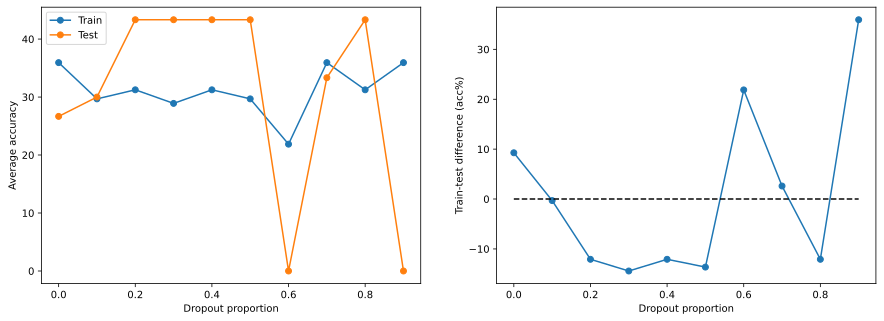

In [137]:
# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

# Experiments

1. Change the activation function into a different activation function and re-run the code, compare the result with the ReLU activation function. Does different activation function affect the performance of the dropout?

2. Create a wide network using ReLU as the activation function and conduct the same experiment, compare the result to that of the original code.

3. Create a more complex model by adding more layers into the architecture, conduct the same experiment, compare the result to that of the original code.